<a href="https://colab.research.google.com/github/peeyushsinghal/EVA8/blob/main/S8-Assignment-Solution/EVA8_S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title importing model, mains, utils
!git clone https://github.com/peeyushsinghal/pytorch-models-utils.git
import os
os.getcwd() 
os.chdir('pytorch-models-utils')

Cloning into 'pytorch-models-utils'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 74 (delta 34), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), 23.02 KiB | 1.21 MiB/s, done.


In [2]:
#@title setting seed and device

# loading helper functions
from utils.helper import seed_all, get_device, get_mean_std_dev

# check for default device

device = get_device()
print (f' device Status : {device}')

 device Status : cuda


In [3]:
## setting seed for reproducibility
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
seed_all(SEED)

In [4]:
#@title Preparing Data

from utils.helper import get_mean_std_dev

# getting mean and standard deviation of CIFAR 10
mean,std = get_mean_std_dev('CIFAR10')
print (mean, std)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
(0.4913996786152028, 0.4821584083946074, 0.4465309144454644) (0.24703223246328238, 0.2434851280000556, 0.26158784172796423)


In [5]:
#@title applying transformations
from utils.transforms import apply_transforms_custom_resnet

train_transforms, test_transforms = apply_transforms_custom_resnet(mean,std)

In [6]:
#@title Train and Test Data

from torchvision import datasets

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
#@title Labels
labels = trainset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
#@title Train and Test set Dataloader

import torch
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

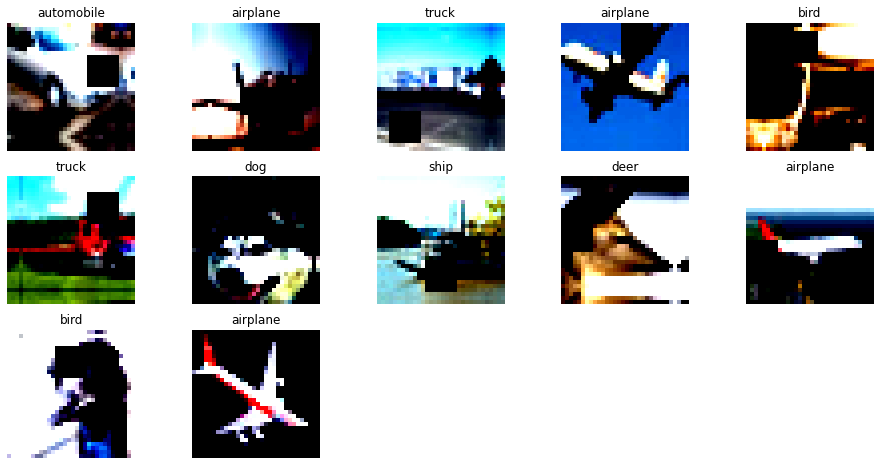

In [9]:
#@title Visualizing Images

from utils.plot_utils import show_batch
show_batch(trainloader,labels,num_images=12) # for visualizing images

In [10]:
#@ Network : Loading Model and understand params, summary
from models.custom_resnet import CustomResnet # Model
from utils.helper import model_summary

model = CustomResnet().to(device)

model_summary(model, input_size =(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
        EnterBlock-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

In [13]:
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.91E-02


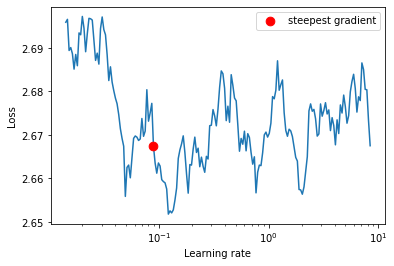

LR at lowest Loss is 0.12173827277396614


In [14]:
#@title One Cycle Policy - Finding max and min learning rates
from torch_lr_finder import LRFinder
from utils.lr_utils import find_lr
import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import copy


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
## make a deep copy of the model ..otherwise this would impact original model
model_copy=copy.deepcopy(model)

max_lr = find_lr(model_copy,optimizer,criterion,testloader) # sending test set as it does not have augmentations



In [16]:
#@title Training and Testing loop

import torch.optim as optim # for optimizer
import torch.nn as nn # for network, criterion
import torch.nn.functional as F 


criterion = nn.CrossEntropyLoss()

# epochs = 40
epochs = 24
lr = 0.1

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                                                 factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=float(max_lr),
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,## how much percent of cycle to use for building up, this gives 5
                                                div_factor=10,## initial lr max/div_factor
                                                three_phase=False, ## no annihilation 
                                                final_div_factor=50,## min lr max/div_factor
                                                anneal_strategy='linear'
                                                ) 



In [17]:
from main import trainer, train, test # including wrapper function of train and test
train_accuracy, train_losses, test_accuracy, test_losses = trainer(model,device, trainloader, testloader, optimizer,epochs,criterion,scheduler)


EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Loss=1.7752549648284912 Batch_id=390 Accuracy=21.42: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]



Test set: Average loss: 0.0002, Accuracy: 3336/10000 (33.36%)

EPOCH: 2


Loss=1.8387399911880493 Batch_id=390 Accuracy=37.89: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]



Test set: Average loss: 0.0001, Accuracy: 4801/10000 (48.01%)

EPOCH: 3


Loss=1.3685715198516846 Batch_id=390 Accuracy=49.91: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]



Test set: Average loss: 0.0001, Accuracy: 5566/10000 (55.66%)

EPOCH: 4


Loss=0.9138039350509644 Batch_id=390 Accuracy=60.03: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s]



Test set: Average loss: 0.0001, Accuracy: 6583/10000 (65.83%)

EPOCH: 5


Loss=1.1115052700042725 Batch_id=390 Accuracy=66.21: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.0001, Accuracy: 6946/10000 (69.46%)

EPOCH: 6


Loss=0.7546478509902954 Batch_id=390 Accuracy=70.64: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0001, Accuracy: 7463/10000 (74.63%)

EPOCH: 7


Loss=0.7326165437698364 Batch_id=390 Accuracy=74.79: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s]



Test set: Average loss: 0.0000, Accuracy: 7724/10000 (77.24%)

EPOCH: 8


Loss=0.7907453775405884 Batch_id=390 Accuracy=77.24: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]



Test set: Average loss: 0.0000, Accuracy: 8026/10000 (80.26%)

EPOCH: 9


Loss=0.4045490324497223 Batch_id=390 Accuracy=79.48: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]



Test set: Average loss: 0.0001, Accuracy: 7981/10000 (79.81%)

EPOCH: 10


Loss=0.412581205368042 Batch_id=390 Accuracy=81.31: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]



Test set: Average loss: 0.0000, Accuracy: 8296/10000 (82.96%)

EPOCH: 11


Loss=0.4959295392036438 Batch_id=390 Accuracy=83.16: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.0000, Accuracy: 8255/10000 (82.55%)

EPOCH: 12


Loss=0.30953893065452576 Batch_id=390 Accuracy=84.56: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0000, Accuracy: 8390/10000 (83.90%)

EPOCH: 13


Loss=0.401563823223114 Batch_id=390 Accuracy=85.45: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.0000, Accuracy: 8379/10000 (83.79%)

EPOCH: 14


Loss=0.3976286053657532 Batch_id=390 Accuracy=86.31: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.0001, Accuracy: 8278/10000 (82.78%)

EPOCH: 15


Loss=0.22230128943920135 Batch_id=390 Accuracy=87.59: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 0.0000, Accuracy: 8505/10000 (85.05%)

EPOCH: 16


Loss=0.4262942373752594 Batch_id=390 Accuracy=88.90: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 0.0000, Accuracy: 8541/10000 (85.41%)

EPOCH: 17


Loss=0.41948193311691284 Batch_id=390 Accuracy=89.35: 100%|██████████| 391/391 [00:34<00:00, 11.38it/s]



Test set: Average loss: 0.0000, Accuracy: 8527/10000 (85.27%)

EPOCH: 18


Loss=0.268311083316803 Batch_id=390 Accuracy=90.04: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]



Test set: Average loss: 0.0000, Accuracy: 8636/10000 (86.36%)

EPOCH: 19


Loss=0.24494735896587372 Batch_id=390 Accuracy=90.93: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s]



Test set: Average loss: 0.0000, Accuracy: 8637/10000 (86.37%)

EPOCH: 20


Loss=0.2649880051612854 Batch_id=390 Accuracy=91.68: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.0000, Accuracy: 8679/10000 (86.79%)

EPOCH: 21


Loss=0.33905503153800964 Batch_id=390 Accuracy=92.08: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s]



Test set: Average loss: 0.0000, Accuracy: 8681/10000 (86.81%)

EPOCH: 22


Loss=0.16821610927581787 Batch_id=390 Accuracy=92.82: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s]



Test set: Average loss: 0.0000, Accuracy: 8699/10000 (86.99%)

EPOCH: 23


Loss=0.19766494631767273 Batch_id=390 Accuracy=93.46: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]



Test set: Average loss: 0.0000, Accuracy: 8738/10000 (87.38%)

EPOCH: 24


Loss=0.14548087120056152 Batch_id=390 Accuracy=93.42: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]



Test set: Average loss: 0.0000, Accuracy: 8720/10000 (87.20%)



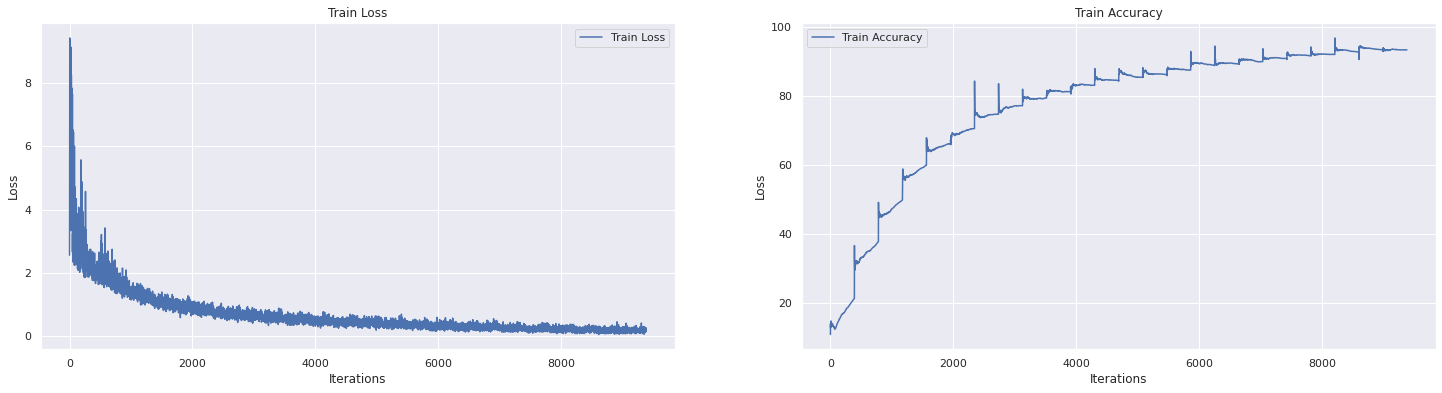

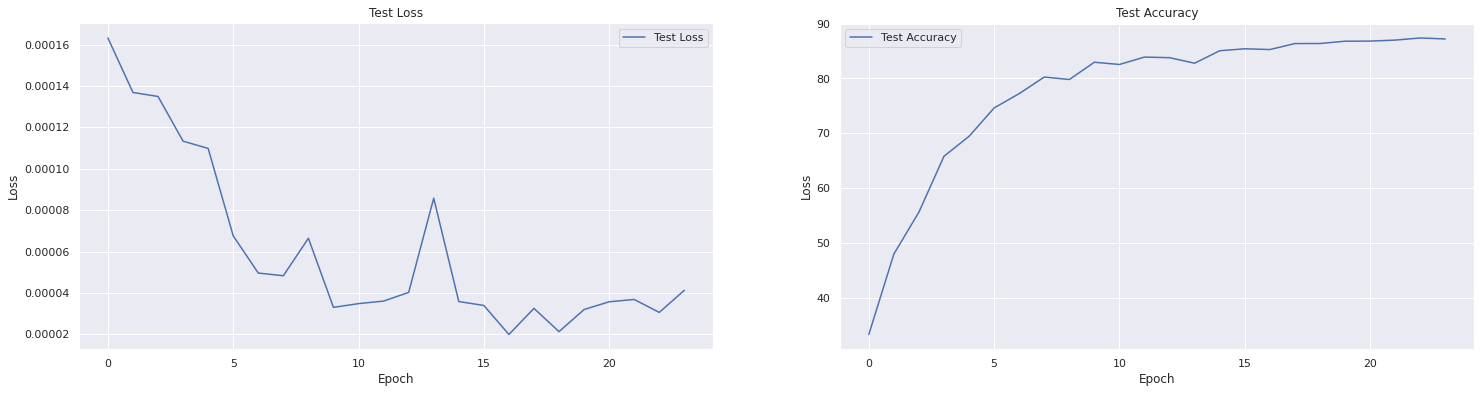

In [18]:
#@title checking results
from utils.plot_utils import plot_metrics

plot_metrics(train_accuracy, [x.cpu().detach().numpy() for x in train_losses], test_accuracy, test_losses)

In [19]:
#@title Checking class level accuracy
from utils.helper import evaluate_classwise_accuracy
evaluate_classwise_accuracy(model, device, labels, testloader)

Accuracy of airplane : 89 %
Accuracy of automobile : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 79 %
Accuracy of  deer : 88 %
Accuracy of   dog : 75 %
Accuracy of  frog : 83 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %


Total wrong predictions are 1280


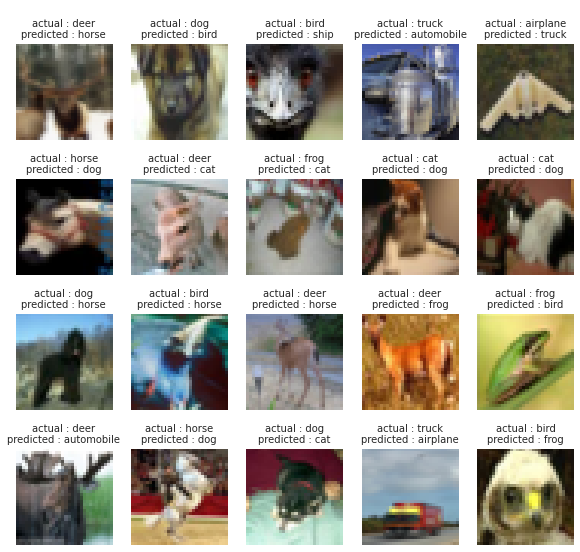

In [20]:
#@title Misclassified Images
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(model, testloader, device, mean, std)

Generating Grad-CAM for layer_1_entry
Generating Grad-CAM for layer2
Generating Grad-CAM for layer_3_entry


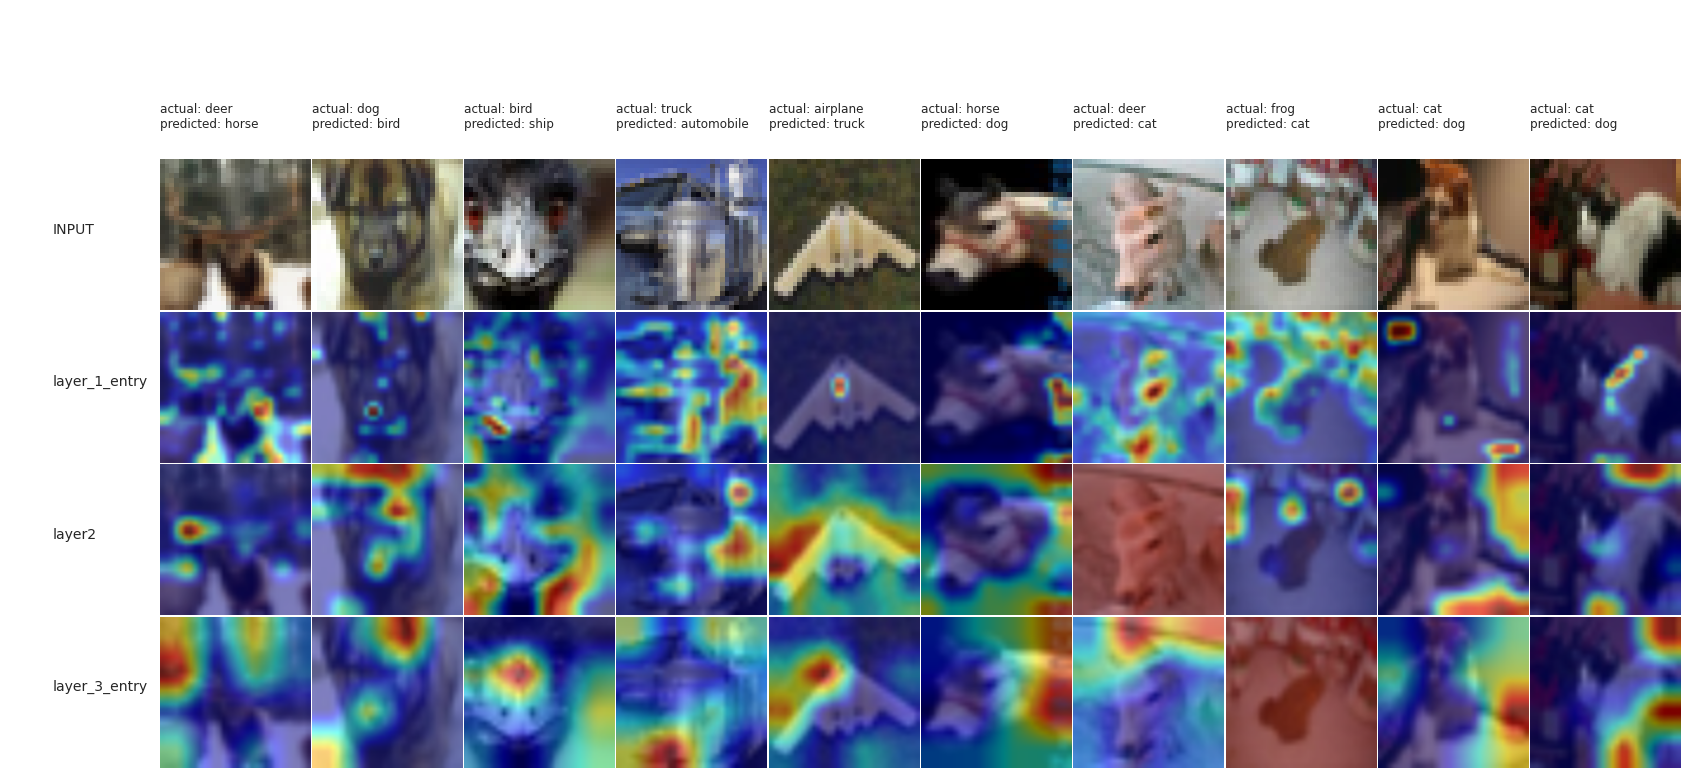

In [23]:
#@title Grad Cam on misclassified images

from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer_1_entry", "layer2", "layer_3_entry"]
gradcam_output, probs, predicted_classes = generate_gradcam(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[:10])